In [1]:
from utils.task import get_input
from utils.analysis import get_attractors, plot_hiddens_and_data, get_speed, visualize_fixed_points, is_stable, get_all_hiddens, minimize_speed, get_all_hiddens, filter_fixed_points
from utils.model import plot_behavior
from utils.utils import get_model, get_metrics_path

import torch
import json
import matplotlib.pyplot as plt

/Users/slibkind/opt/anaconda3/envs/multitask-rnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i):
    input1 = get_input(task_idx[0], period[0], stimulus[0], tasks)
    input2 = get_input(task_idx[1], period[1], stimulus[1], tasks)

    interpolated_input = (n_interp - step_i)/n_interp * input1 + (step_i/n_interp) * input2
    return interpolated_input

def find_fixed_points(rnn, tasks, input, learning_rate, grad_threshold):
    sample_proportion = 0.1   # proportion of all hidden states to be sampled

    # Load model and get initial conditions for finding fixed points
    all_hiddens = get_all_hiddens(rnn, tasks)

    # Determine the number of samples from the proportion of hidden states
    hidden_state_count = all_hiddens.size(0)
    num_samples = int(hidden_state_count * sample_proportion)  # Calculate the number of samples

    # Randomly permute the indices and select the first num_samples
    indices = torch.randperm(hidden_state_count)[:num_samples]  
    sampled_hiddens = all_hiddens[indices]  # Select the sampled hidden points using the sampled indices

    fps = minimize_speed(rnn, input, sampled_hiddens, learning_rate, grad_threshold, method='second')

    return fps.detach()

def plot_performance(model_name):
    metrics_path = get_metrics_path(model_name)
    # Load performance metrics from the JSON file
    with open(metrics_path, "r") as f:
        performance_metrics = json.load(f)

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(12, 6))
    plt.plot(performance_metrics["epochs"][1:], performance_metrics["val_loss"][1:], label='Validation Loss')
    plt.plot(performance_metrics["epochs"][1:], performance_metrics["avg_loss"][1:], label='Average Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()


In [3]:
# Select a model

model_name = "delaygo_delayanti_256"
rnn, tasks = get_model(model_name)#, epoch = '2000')

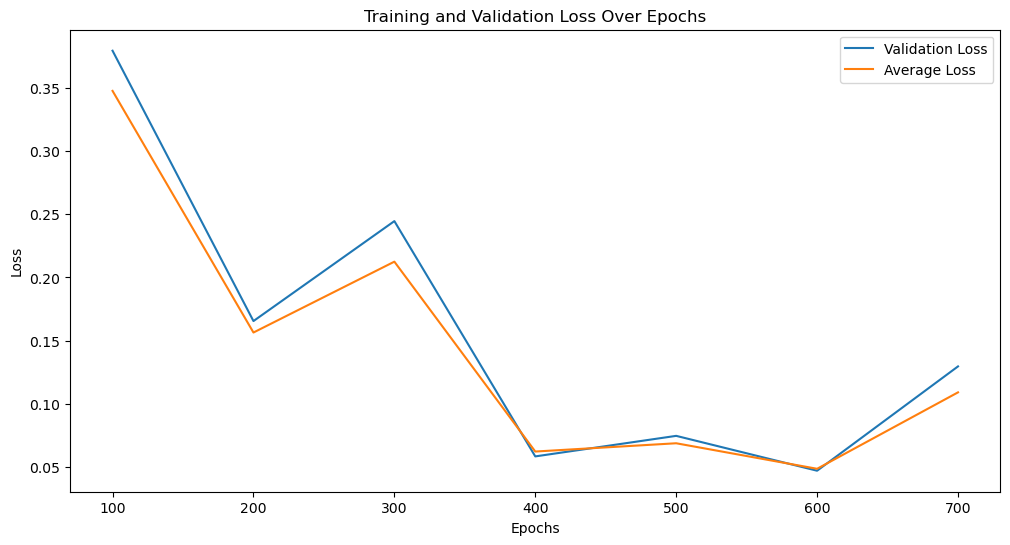

In [4]:
# Network performance over training
plot_performance(model_name)

## Network behavior

Plot the behavior of the model on all input sequences for all tasks. Use larger period durations to test if the computation is time-independent.

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


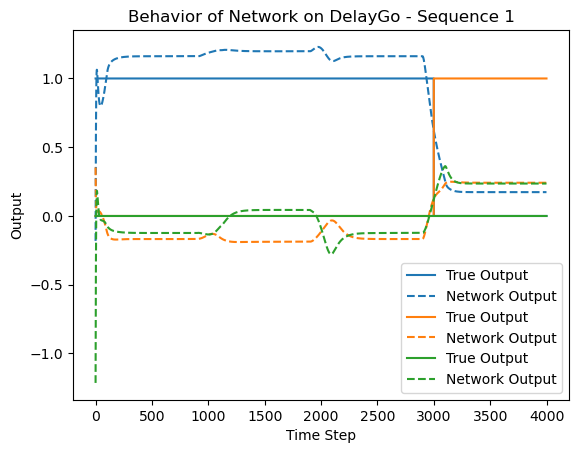

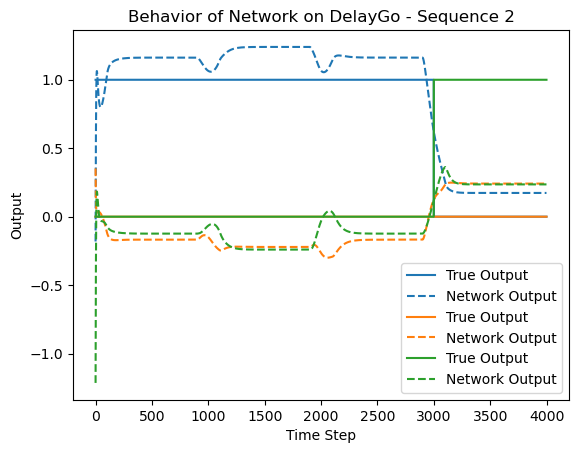

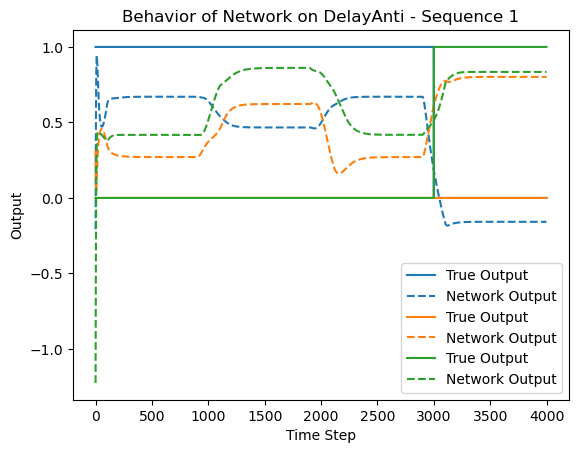

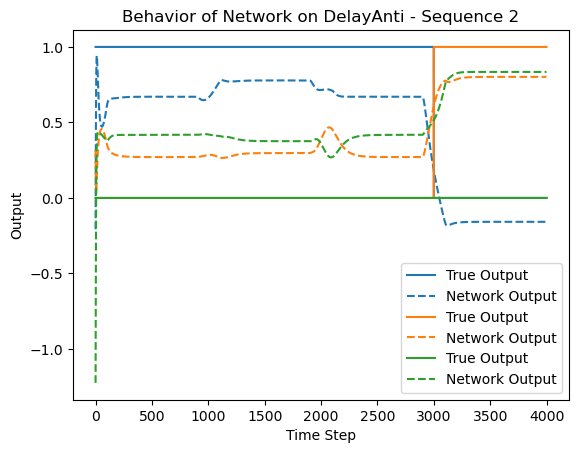

In [5]:
period_duration=1000
smoothing_window = int(period_duration * 0.2)
plot_behavior(rnn, tasks, period_duration=period_duration, smoothing_window=smoothing_window)

## Fixed points for a single input

In [6]:
# Set the input

interpolate = False    # Variable for interpolated vs. direct input

if not interpolate:
  # Parameters for input computed directly from task
  task_idx = 0
  period = "stim"
  stimulus = 2
  input = get_input(task_idx, period, stimulus, tasks)
  
else:
  # Paramters for interpolated input
  task_idx = [0,1]
  period = ["delay", "delay"]
  stimulus = [1, 1]
  n_interp = 20
  step_i = 10

  input = interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i)


print(f"The input is {input.numpy()}.")

The input is [1. 0. 1. 1. 0.].


In [7]:
# Parameters for finding fixed points
learning_rate = 0.1
grad_threshold = 1e-3

fps = find_fixed_points(rnn, tasks, input, learning_rate, grad_threshold)

Iteration 0: maximum gradient norm across all initial conditions is 0.5619510412216187
Time taken for the last 10000 iterations: 0.07140779495239258 seconds.
Stopping optimization: maximum gradient norm across all initial conditions is below the threshold.


In [8]:
unique = True
q_thresh = 1e-1
eps = 0.3

# Compute the stability of each point
stability = torch.tensor([is_stable(rnn, point, input) for point in fps], dtype=torch.bool)

# Split fixed points into stable and unstable
stable_fps = fps[stability]
unstable_fps = fps[~stability]

stable_fps = filter_fixed_points(model_name, input, stable_fps, q_thresh=q_thresh, unique=True, eps=eps)
unstable_fps = filter_fixed_points(model_name, input, unstable_fps, q_thresh=q_thresh, unique=True, eps=eps)

print(f"There are {len(stable_fps)} unique stable fixed points.")
print(f"There are {len(unstable_fps)} unique unstable fixed points.")

There are 1 unique stable fixed points.
There are 0 unique unstable fixed points.


In [9]:
speeds = get_speed(rnn, input, stable_fps.float())
for i, fp in enumerate(stable_fps):
    print(f"Stable fixed point {i} has speed {speeds[i]}")

print("\n")

speeds = get_speed(rnn, input, unstable_fps.float())
for i, fp in enumerate(unstable_fps):
    print(f"Unstable fixed point {i} has speed {speeds[i]}")

Stable fixed point 0 has speed 1.2109533997772814e-07




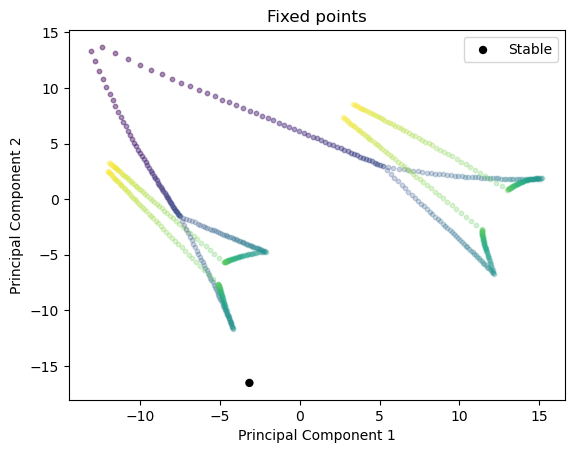

In [10]:
# Plot the fixed points
# Prepare data lists
data_tensors = []
labels = []
fills = []

if stable_fps.numel() > 0:  # if the list is not empty
    data_tensors.append(stable_fps)
    labels.append('Stable')
    fills.append(True)

if unstable_fps.numel() > 0:  # if the list is not empty
    data_tensors.append(unstable_fps)
    labels.append('Unstable')
    fills.append(False)

# Plot only if we have any data to plot
if data_tensors:
    plot_hiddens_and_data(rnn, tasks, 
                          data_tensors, 
                          label_list = labels,
                          filled_list = fills,
                          title = "Fixed points")
else:
    print("No fixed points to plot.")

## Fixed points for interpolated inputs

<Axes: title={'center': 'Comparing stimuli in the DelayGo task'}, xlabel='Interpolation Step', ylabel='First Principal Component'>

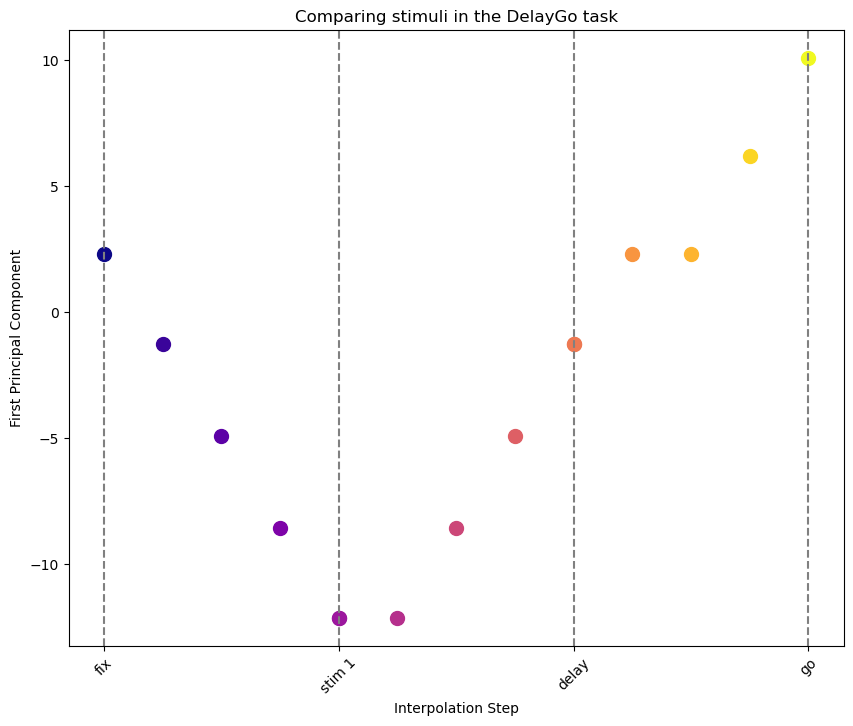

In [13]:
task_idx = [1, 1, 1, 1]
period = ["fix", "stim", "delay", "go"]
stimulus = [2, 2, 2, 2]
n_interp = 4
labels = ["fix", "stim 1" , "delay", "go"]
title = "Comparing stimuli in the DelayGo task"
q_thresh = None
eps = 0.3

epoch = 700

visualize_fixed_points(model_name, epoch, task_idx, period, stimulus, n_interp, input_labels = labels, title = title, q_thresh=q_thresh, eps=eps)

## Attractors for a single input

It is also sometimes useful to find the attractors for a single input by running the network forwards and visualizing the points to which it converges. Unlike fixed point finder, this method can find attractors with more complex topologies. However, this method cannot be used to find unstable invariant sets. 

In [13]:
# Set the input

interpolate = False    # Variable for interpolated vs. direct input

if interpolate:
  # Paramters for interpolated input
  task_idx = [0,1]
  period = ["delay", "delay"]
  stimulus = [1, 1]
  n_interp = 20
  step_i = 3

  input = interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i)

else:
  # Parameters for input computed directly from task
  task_idx = 0
  period = "delay"
  stimulus = 1
  input = get_input(task_idx, period, stimulus, tasks)

print(f"The input is {input.numpy()}.")

The input is [1. 0. 0. 1. 0.].


In [10]:
all_hiddens = get_all_hiddens(rnn, tasks)
num_timesteps = 3000
num_last = 100

attractors = get_attractors(rnn, input, all_hiddens, num_timesteps, num_last)

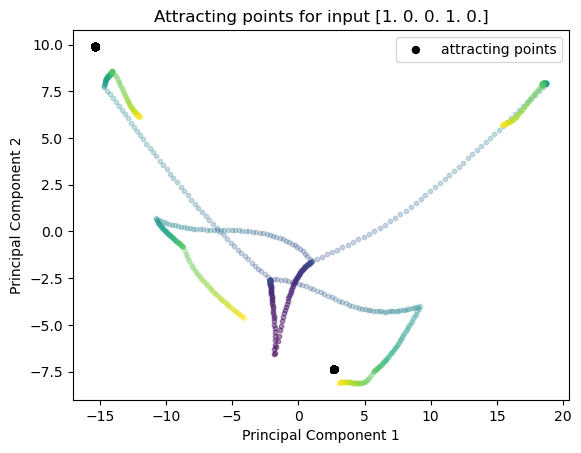

In [12]:
attractors = attractors.reshape(-1, attractors.shape[-1])
plot_hiddens_and_data(rnn, tasks, [attractors], 
                      label_list = ["attracting points"], 
                      title = f"Attracting points for input {input.numpy()}"
)